<a href="https://colab.research.google.com/github/laurenwisniewski/DS4002-Project-3/blob/main/DS_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from scipy.spatial.distance import cdist
from skimage import metrics

Load and preprocess data

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = np.expand_dims(x_train, axis = -1).astype('float32') / 255
x_test = np.expand_dims(x_test, axis = -1).astype('float32') / 255

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

EDA: create histograms to show distributions of class labels for training images

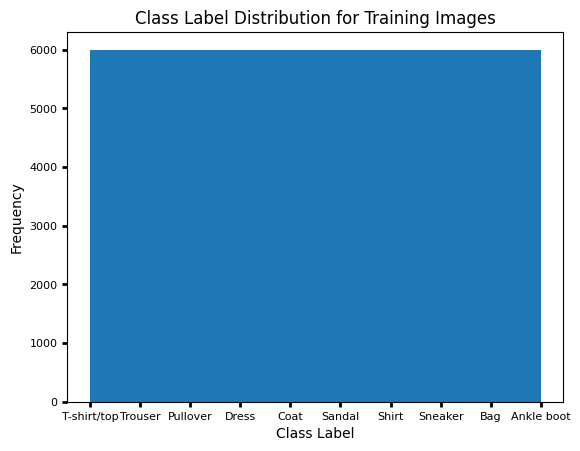

In [23]:
plt.hist(y_train)
plt.title('Class Label Distribution for Training Images')
plt.xlabel('Class Label')
xticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
xlabels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.xticks(xticks, labels = xlabels)
plt.tick_params(labelsize = 8, width = 2)
plt.ylabel('Frequency')
plt.show()

EDA: create histograms to show distributions of class labels for test images

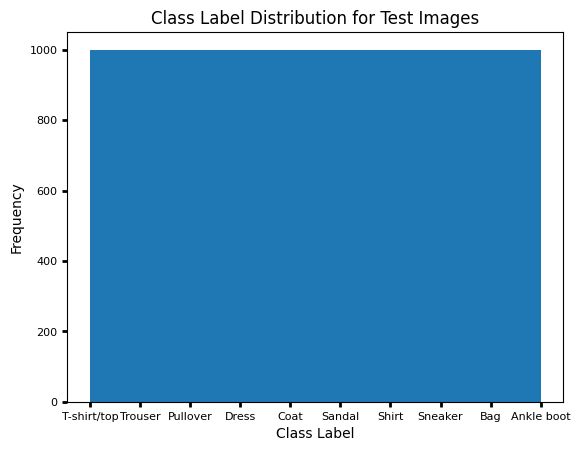

In [20]:
plt.hist(y_test)
plt.title('Class Label Distribution for Test Images')
plt.xlabel('Class Label')
xticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
xlabels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.xticks(xticks, labels = xlabels)
plt.tick_params(labelsize = 8, width = 2)
plt.ylabel('Frequency')
plt.show()

EDA: view some sample training images

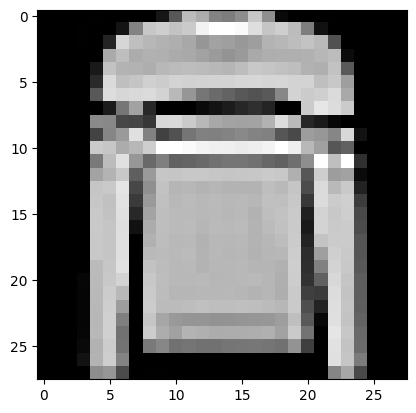

In [30]:
plt.imshow(x_train[5].reshape(28, 28))
plt.gray()

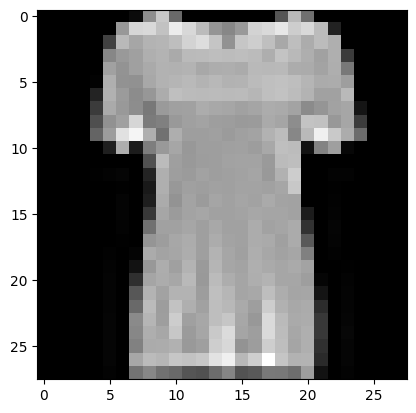

In [31]:
plt.imshow(x_train[10].reshape(28, 28))
plt.gray()

EDA: view some sample test images

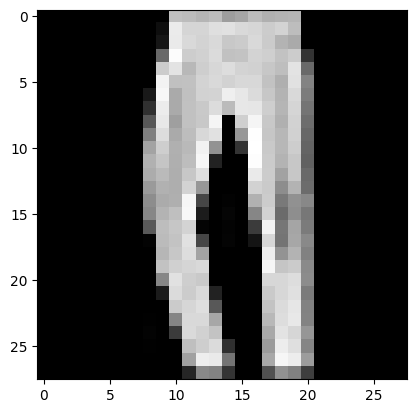

In [32]:
plt.imshow(x_test[5].reshape(28, 28))
plt.gray()

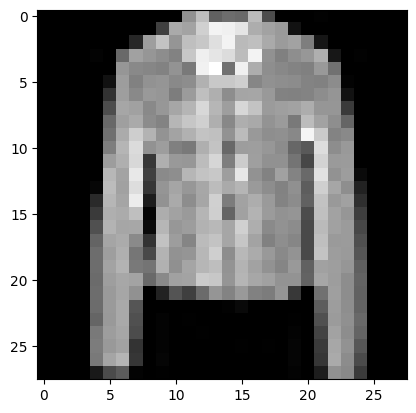

In [33]:
plt.imshow(x_test[10].reshape(28, 28))
plt.gray()

Build and compile CNN-based autoencoder

In [21]:
# Input layer: accepts images of shape 28 x 28 x 1
input_img = Input(shape=(28, 28, 1))

# Encoder
# Convolutional layer with 32 filters, each 3x3, using 'relu' activation. 'same' padding ensures output size matches input size
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input_img)
# Max pooling layer to reduce spatial dimensions by half
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(x)
encoded = MaxPooling2D((2, 2), padding = 'same')(x)

# Decoder
# Convolutional layer with 8 filters to start decoding the compressed representations
x = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(encoded)
# Upsampling layer to start expanding the spatial dimensions back to the original size
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation = 'relu')(x)
# Final upsampling to match the original image dimensions
x = UpSampling2D((2, 2))(x)
# Output layer to reconstruct the original image
decoded = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(x)

# Compile the autoencoder model with Adam optimizer and binary cross-entropy loss
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer = Adam(), loss = 'binary_crossentropy')

Train the autoencoder using training images

In [22]:
autoencoder.fit(x_train, x_train, epochs = 5, batch_size = 128, shuffle = True, validation_data = (x_test, x_test))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 119s 247ms/step - loss: 0.4012 - val_loss: 0.3026
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 133s 228ms/step - loss: 0.2978 - val_loss: 0.2944
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 225ms/step - loss: 0.2915 - val_loss: 0.2908
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 144s 229ms/step - loss: 0.2887 - val_loss: 0.2885
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 106s 227ms/step - loss: 0.2865 - val_loss: 0.2868


Generate embeddings for the test images

In [25]:
encoder = Model(autoencoder.input, autoencoder.layers[-7].output)
encoded_imgs = encoder.predict(np.reshape(x_test, (len(x_test), 28, 28, 1)))
encoded_imgs_flatten = encoded_imgs.reshape((len(x_test), np.prod(encoded_imgs.shape[1:])))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


Find indices of similar images based on embeddings

In [26]:
np.random.seed(3)
selected_indices = np.random.choice(x_test.shape[0], 3, replace = False)
similar_images_indices = []
for index in selected_indices:
    distances = cdist(encoded_imgs_flatten[index: index + 1], encoded_imgs_flatten, 'euclidean')
    closest_indices = np.argsort(distances)[0][1:4]  # Exclude original image
    similar_images_indices.append(closest_indices)

Display the original and similar images

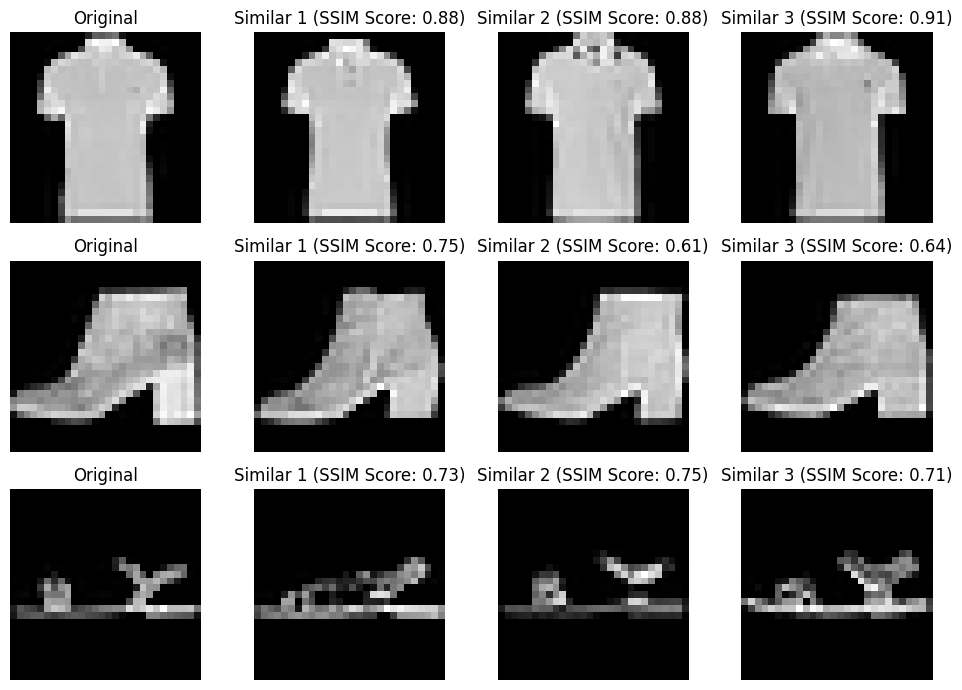

In [27]:
plt.figure(figsize = (10, 7))
for i, (index, sim_indices) in enumerate(zip(selected_indices, similar_images_indices)):
  ax = plt.subplot(3, 4, i * 4 + 1)
  original = np.squeeze(x_test[index])
  plt.imshow(x_test[index].reshape(28, 28))
  plt.title(f'Original')
  plt.gray()
  ax.axis('off')

  for j, sim_index in enumerate(sim_indices):
    ax = plt.subplot(3, 4, i * 4 + j + 2)
    plt.imshow(x_test[sim_index].reshape(28, 28))
    similar = np.squeeze(x_test[sim_index])
    ssim_score = metrics.structural_similarity(original, similar, full = True, data_range = 2)
    plt.title(f'Similar {j + 1} (SSIM Score: {round(ssim_score[0], 2)})')
    plt.gray()
    ax.axis('off')
plt.tight_layout()
plt.show()